# Establish thresholds for mutational signature classifications

## 1 Preprocessing and Data Import

In [1]:
%load_ext autoreload
%autoreload 2
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import signatureanalyzer as sa
import seaborn as sns
import sys
import math
import itertools
import os

sys.path.append("/home/yakiyama/CPTAC_PanCan_2021/funcs/")
import ms_utils
import plotting as pl

In [2]:
# Define file paths
H_MUT_PATH = "gs://cptac-pancan-getzlab/Freeze_061721/mutational_signatures/Full_H_compressed_v1.1.tsv"
SAMPLE_MAP_PATH = "gs://cptac-pancan-getzlab/mapping/PanCan_Participant_freeze_mapping.tsv"
DENDRO_SUBTYPE_PATH = "gs://cptac-pancan-getzlab/Freeze_061721/dendrogram/dendro_map_with_subtype.tsv"
HRD_SPECTRA_PATH = "/home/yakiyama/CPTAC_Signatures/spectra/MMRP/HRD_COMPOSITE96_c2a_filtered.tsv"
MAF_PATH = "gs://cptac-pancan-getzlab/Freeze_050721/Somatic_WXS/union_somatic_maf_v1.1_hotspot_cptac2fix.maf"
GERMLINE_WXS_DIR = "gs://cptac-pancan-getzlab/germline_WXS"


In [3]:
# Load signature and sample id data
H_mut = pd.read_csv(H_MUT_PATH, sep='\t',index_col=0)
sample_map = pd.read_csv(SAMPLE_MAP_PATH, sep='\t')
sample_map.index = sample_map.index.astype(str)

# Define cohort dataframe
cohort_df = sample_map.copy()
cohort_df = cohort_df[cohort_df['cohort'] != 'MEDUL']
cohort_df = cohort_df[cohort_df['WXS'].isin(H_mut.index.to_list())]
cohort_df = cohort_df[['WXS','cohort']].rename(columns={'WXS':'sample'})

# Define participant ID to WXS ID annotation dictionary
participant2WXS_d = sample_map.set_index('participant_id').to_dict()['WXS']
proteomic2WXS_d = sample_map.set_index('Proteome_Sample_ID').to_dict()['WXS']

# Import subtype and dendrogram information
meta_df = pd.read_csv(DENDRO_SUBTYPE_PATH, sep='\t', index_col=0)

# Standardize sample IDs
meta_df.index = meta_df.index.map(proteomic2WXS_d)

# Subset for relevant samples]
H_mut.index = H_mut.index.astype(str)
meta_df.index = meta_df.index.astype(str)
meta_df = meta_df.loc[np.intersect1d(meta_df.index, H_mut.index.astype(str))]

In [4]:
# Load germline wxs mafs
brca_germ_df = pd.read_csv(os.path.join(GERMLINE_WXS_DIR, "BR_germline_mutation.maf.gz"), sep='\t', comment="#")
hgsc_germ_df = pd.read_csv(os.path.join(GERMLINE_WXS_DIR, "OV_germline_mutation.maf.gz"), sep='\t', comment="#")
pdac_germ_df = pd.read_csv(os.path.join(GERMLINE_WXS_DIR, "PDA_germline_mutation.maf.gz"), sep='\t', comment="#")

/home/yakiyama/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/yakiyama/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 2.1 Homologous recombination deficiency classification informed by germline WXS

In [5]:
# Identify pathogenic germline variants
CLIN_SIG = ["benign,pathogenic", "pathogenic,risk_factor", "likely_benign,pathogenic", 
            'uncertain_significance,pathogenic','likely_pathogenic,pathogenic', 'pathogenic',
            'uncertain_significance,benign,pathogenic,risk_factor', 
            'uncertain_significance,not_provided,likely_pathogenic,pathogenic,risk_factor',
            'uncertain_significance,likely_benign,pathogenic']
def get_pathogenic(gene):
    brca_pathogenic = brca_germ_df[(brca_germ_df['Hugo_Symbol']==gene) & 
                                   ((brca_germ_df['IMPACT']=='HIGH') | (brca_germ_df['CLIN_SIG'].str.contains('pathogenic')))]['Tumor_Sample_Barcode']
    hgsc_pathogenic = hgsc_germ_df[(hgsc_germ_df['Hugo_Symbol']==gene) & 
                                   ((hgsc_germ_df['IMPACT']=='HIGH') | (hgsc_germ_df['CLIN_SIG'].str.contains('pathogenic')))]['Tumor_Sample_Barcode']
    pdac_pathogenic = pdac_germ_df[(pdac_germ_df['Hugo_Symbol']==gene) & 
                                   ((pdac_germ_df['IMPACT']=='HIGH') | (pdac_germ_df['CLIN_SIG'].str.contains('pathogenic')))]['Tumor_Sample_Barcode']
    return brca_pathogenic.append(hgsc_pathogenic).append(pdac_pathogenic)

BRCA1_pathogenic = get_pathogenic("BRCA1")
BRCA2_pathogenic = get_pathogenic("BRCA2")
PALB2_pathogenic = get_pathogenic("PALB2")
RAD51C_pathogenic = get_pathogenic("RAD51C")
BARD1_pathogenic = get_pathogenic("BARD1")
BRIP1_pathogenic = get_pathogenic("BRIP1")
NBN_pathogenic = get_pathogenic("NBN")
ATM_pathogenic = get_pathogenic("ATM")
CHEK2_pathogenic = get_pathogenic("CHEK2")
FANCA_pathogenic = get_pathogenic("FANCA")
FANCM_pathogenic = get_pathogenic("FANCM")




In [5]:
def prep_plotting_df(H, color_scheme, cohort_df, signature):
    cohort_dict = dict(zip(cohort_df['sample'],cohort_df['cohort']))

    H_norm = H.div(H.sum(1), axis=0)
    sig_norm = H_norm[H_norm[signature] > 0].sort_values(by=signature)
    sig_raw = H[H[signature] > 0].sort_values(by=signature)

    sig_plot = pd.concat([sig_raw[signature].rename('raw'), sig_norm[signature].rename('norm')], axis=1)
    sig_plot['cohort'] = sig_plot.index.map(cohort_dict)
    sig_plot['color'] = sig_plot['cohort'].map(color_scheme)

    return sig_plot


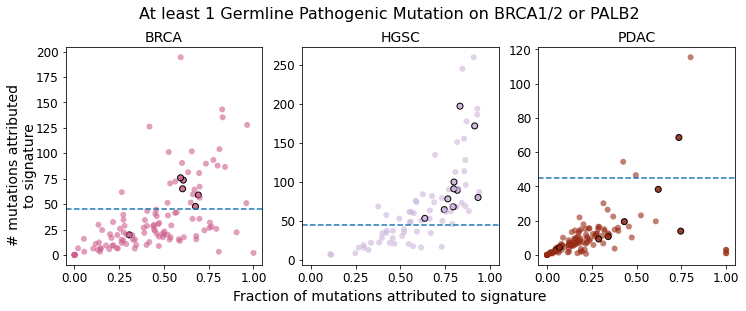

In [31]:
## Plot raw and fractional mutation counts for SBS3 and mark tumors with a somatic mutation on an HRD gene
plot_df = prep_plotting_df(H_mut, color_scheme=pl.CPTAC_CMAP, cohort_df=cohort_df, signature='HRD')
plot_df['brca1_brca2_palb2_germline'] = plot_df.index.isin([participant2WXS_d[x] for x in BRCA1_pathogenic.append(BRCA2_pathogenic.append(PALB2_pathogenic))])

plot_df['color'] = plot_df['color'].map(lambda x: tuple(int(x.lstrip("#")[i:i+2], 16)/255 for i in (0, 2, 4)))
plot_df['color'] = plot_df.apply(lambda x: tuple([col for col in x['color']] + [0.9]) if x['brca1_brca2_palb2_germline']==True else
                                 tuple([col for col in x['color']] + [0.6]), 1)
plot_df['cohort'] = plot_df['cohort'].map(lambda x: x if x != 'OV' else 'HGSC')
plot_df = plot_df.sort_values(['cohort'])
figure, ax = plot_norm_raw_sigs(plot_df.drop('04OV036_T'), raw_thresh = 45, norm_thresh = 0,
                                show_raw_thresh=True, show_norm_thresh=False, sharey=False,
                                circle='brca1_brca2_palb2_germline', 
                                title='At least 1 Germline Pathogenic Mutation on BRCA1/2 or PALB2',
                                height=4, width=12, plot_all=False, nrows=1, ncols=3, 
                                xlabel_coords=(0.5, 0), ylabel_coords=(0.075, 0.2),
                                fig_suptitle_ycoord=1.02, 
                                ylabel="# mutations attributed\nto signature", 
                                show_legend=False, fig_suptitle_size=16, 
                                xlabel_size=14, ylabel_size=14, alpha=0.5
                               )
ax[0].set_title("BRCA", size=14)
ax[1].set_title("HGSC", size=14)
ax[2].set_title("PDAC", size=14)
ax[0].tick_params(axis='y', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)
ax[2].tick_params(axis='y', labelsize=12)
ax[0].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='x', labelsize=12)
ax[2].tick_params(axis='x', labelsize=12)
figure.savefig("figures/Figure_S3B_HRD_threshold.pdf", 
               dpi=100, bbox_inches='tight')



## 2.2 Tobacco Smoking Signature

Text(0.5, 1.0, 'LSCC')

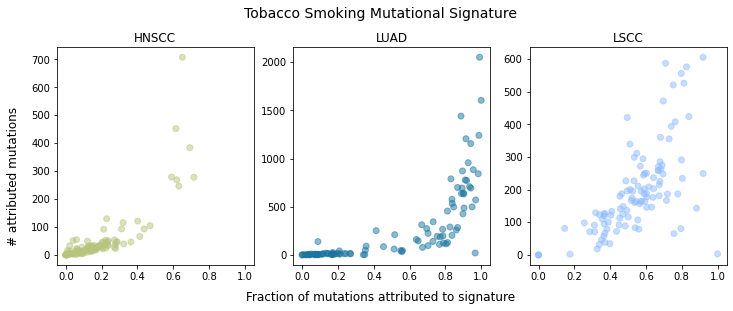

In [6]:
plot_df = prep_plotting_df(
    H_mut, color_scheme=pl.CPTAC_CMAP, cohort_df=cohort_df, signature='Tobacco Smoking'
)
plot_df['cohort_idx'] = plot_df['cohort'].map({"HNSCC":0, "LUAD":1, "LSCC":2})
plot_df = plot_df.sort_values('cohort_idx')
figure, ax = ms_utils.plot_norm_raw_sigs(
    plot_df,raw_thresh = 50, norm_thresh = 0.4, 
    show_raw_thresh=False, show_norm_thresh=False, 
    sharey=False, plot_all=False, nrows=1, ncols=3, 
    height=4, width=12,
    title='Tobacco Smoking Mutational Signature',
    xlabel_coords=(0.5, 0), ylabel_coords=(0.075, 0.2),
    fig_suptitle_ycoord=1.02, ylabel="# attributed mutations",
    show_legend=False, fig_suptitle_size=14, xlabel_size=12, ylabel_size=12
)
ax[0].set_title("HNSCC", size=12)
ax[1].set_title("LUAD", size=12)
ax[2].set_title("LSCC", size=12)

# ax[0,0].tick_params(axis='y', labelsize=12)
# ax[1,0].tick_params(axis='y', labelsize=12)
# ax[1,0].tick_params(axis='x', labelsize=12)
# ax[1,1].tick_params(axis='x', labelsize=12)


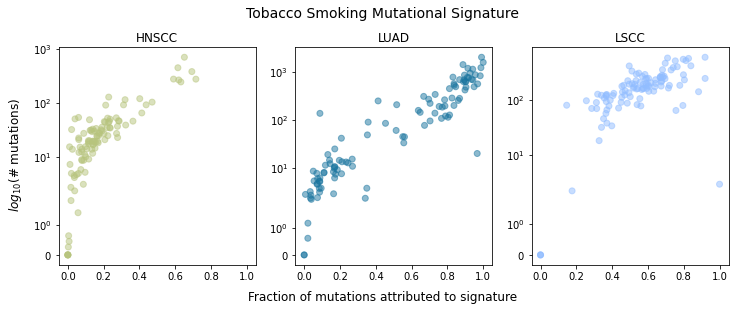

In [23]:
plot_df = prep_plotting_df(
    H_mut, color_scheme=pl.CPTAC_CMAP, cohort_df=cohort_df, signature='Tobacco Smoking'
)
plot_df['raw'] = plot_df['raw'].map(lambda x: x)
plot_df['cohort_idx'] = plot_df['cohort'].map({"HNSCC":0, "LUAD":1, "LSCC":2})
plot_df = plot_df.sort_values('cohort_idx')
figure, ax = ms_utils.plot_norm_raw_sigs(
    plot_df,raw_thresh = 50, norm_thresh = 0.4, 
    show_raw_thresh=False, show_norm_thresh=False, 
    sharey=False, plot_all=False, nrows=1, ncols=3, 
    height=4, width=12,
    title='Tobacco Smoking Mutational Signature',
    xlabel_coords=(0.5, 0), ylabel_coords=(0.075, 0.325),
    fig_suptitle_ycoord=1.02, ylabel=u"$log_{10}$(# mutations)",
    show_legend=False, fig_suptitle_size=14, xlabel_size=12, ylabel_size=12
)
ax[0].set_title("HNSCC", size=12)
ax[1].set_title("LUAD", size=12)
ax[2].set_title("LSCC", size=12)
ax[0].set_yscale("symlog")
ax[1].set_yscale("symlog")
ax[2].set_yscale("symlog")
figure.savefig("../figures/mutational_signatures/smoking_signature_distribution.pdf",
               dpi=100, bbox_inches='tight')

## 3 Summarize germline WXS data

In [ ]:
# Load germline wxs mafs
germ_df = pd.DataFrame()
for cohort in ["BR", "OV", "PDA", "CO", "CCRCC", "GBM", "HNSCC", "LSCC", "LUAD", "UCEC"]:
    germ_df = pd.concat([germ_df, pd.read_csv(os.path.join(GERMLINE_WXS_DIR, f"{cohort}_germline_mutation.maf.gz"), sep='\t', comment="#")])

In [11]:
# Subset for samples in the study
germ_df = germ_df[germ_df['Tumor_Sample_Barcode'].isin(sample_map['participant_id'].to_list())]
# Number of variants per patient
var_per_patient_s = germ_df.value_counts('Tumor_Sample_Barcode')
# Plot histogram of variant counts
var_per_patient_s.hist()

/home/yakiyama/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [22]:
print(f"Median number of mutations per patient across all cohorts: {mut_per_patient_s[mut_per_patient_s.index.isin(sample_map['participant_id'].to_list())].sort_values().median()}")

Median number of mutations per patient across all cohorts: 24996.0


## 4 HRD and MMRD cohort + subtype distributions


In [4]:
# Define MMRD and HRD tumors
hrd_tumors_s = H_mut[H_mut['HRD']>=45].index
mmrd_tumors_s = H_mut[H_mut['MMRD']>0].index

# Annotate metadata 
meta_df["HR_Status"] = meta_df.index.map(lambda x: "HRD" if x in hrd_tumors_s else "HRP")
meta_df["MMR_Status"] = meta_df.index.map(lambda x: "MMRD" if x in mmrd_tumors_s else "MMRP")

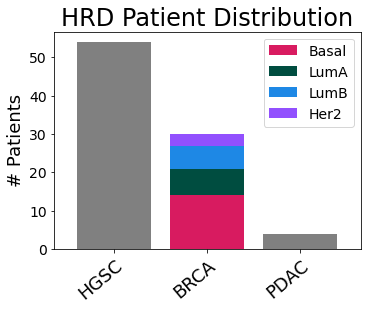

In [9]:
# HRD sample distribution
# rows = cohort
# columns = subtype
hrd_stacked_df = pd.DataFrame(columns=["HGSC","PDAC", "Basal", "LumA", "LumB", "Her2", "Normal-like"], 
                              index=["BRCA", "HGSC", "PDAC"])

hrd_stacked_df.loc['BRCA'] = meta_df[(meta_df['HR_Status']=='HRD') & (meta_df['cohort']=='BRCA')].value_counts('subtype')
hrd_stacked_df.loc['HGSC',"HGSC"] = meta_df[(meta_df['cohort']=='OV') & (meta_df.index.isin(hrd_tumors_s))].shape[0]
hrd_stacked_df.loc['PDAC',"PDAC"] = meta_df[(meta_df['cohort']=='PDAC') & (meta_df.index.isin(hrd_tumors_s))].shape[0]
hrd_stacked_df = hrd_stacked_df.drop(columns=["Normal-like"])

color_map_d = {**pl.PAM50_SUBTYPE_CMAP, **{"HGSC":"#808080", "PDAC":"#808080"}}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5,4))
hrd_stacked_df.loc[["HGSC", "BRCA", "PDAC"]].plot(kind='bar',
                                                  stacked=True,
                                                  width=0.8,
                                                  rasterized=True, 
                                                  ax=ax, 
                                                  color=color_map_d)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[2:], labels=labels[2:], loc='upper right', fontsize=14)
ax.set_ylabel("# Patients", size=18)
cohort_totals = meta_df['cohort'].value_counts()
# ax.set_xticklabels([f"HGSC\n{int(hrd_stacked_df.loc['HGSC'].sum())}/{cohort_totals.loc['OV']}", 
#                     f"BRCA\n{int(hrd_stacked_df.loc['BRCA'].sum())}/{cohort_totals.loc['BRCA']}",
#                     f"PDAC\n{int(hrd_stacked_df.loc['PDAC'].sum())}/{cohort_totals.loc['PDAC']}"], 
#                    rotation=0)
ax.set_xticklabels([f"HGSC", 
                    f"BRCA",
                    f"PDAC"], 
                   rotation=40, ha='right', rotation_mode="anchor", size=18)
ax.set_title("HRD Patient Distribution", size=24)
ax.tick_params(axis='y', labelsize=14)
fig.savefig("../figures/mutational_signatures/hrd_patient_distribution.pdf", bbox_inches="tight")


/home/yakiyama/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator


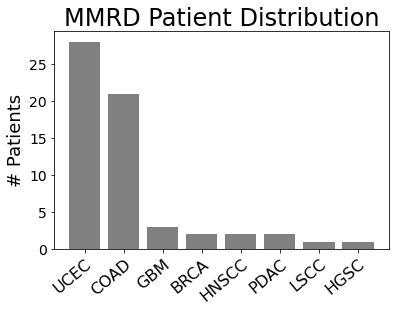

In [8]:
# MMRD tumor distribution
# rows = cohort
# columns = subtype
mmrd_bar_df = pd.DataFrame(index=meta_df[meta_df['MMR_Status']=='MMRD']['cohort'].unique(), columns=["MMRD"])

mmrd_bar_df['MMRD'] = meta_df.loc[mmrd_tumors_s]['cohort'].value_counts()
mmrd_bar_df['color'] = "#808080"
mmrd_bar_df = mmrd_bar_df.reset_index()

# Plot barplot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
for cohort, cohort_df in mmrd_bar_df.sort_values('MMRD',ascending=False).groupby("index", sort=False):
    plt.bar(cohort, cohort_df['MMRD'], label=cohort, align='center', color=cohort_df['color'])
    
ax.set_title("MMRD Patient Distribution", size=24)
ax.set_ylabel("# Patients", size=18)
# ax.set_yticks(size=14)

mmrd_bar_df = mmrd_bar_df.set_index('index')
cohort_totals = meta_df['cohort'].value_counts()
# ax.set_xticklabels([f"UCEC\n{int(mmrd_bar_df.loc['UCEC','MMRD'])}/{cohort_totals.loc['UCEC']}", 
#                     f"COAD\n{int(mmrd_bar_df.loc['COAD','MMRD'])}/{cohort_totals.loc['COAD']}",
#                     f"GBM\n{int(mmrd_bar_df.loc['GBM','MMRD'])}/{cohort_totals.loc['GBM']}", 
#                     f"BRCA\n{int(mmrd_bar_df.loc['BRCA','MMRD'])}/{cohort_totals.loc['BRCA']}", 
#                     f"HNSCC\n{int(mmrd_bar_df.loc['HNSCC','MMRD'])}/{cohort_totals.loc['HNSCC']}", 
#                     f"PDAC\n{int(mmrd_bar_df.loc['PDAC','MMRD'])}/{cohort_totals.loc['PDAC']}", 
#                     f"LSCC\n{int(mmrd_bar_df.loc['LSCC','MMRD'])}/{cohort_totals.loc['LSCC']}", 
#                     f"HGSC\n{int(mmrd_bar_df.loc['OV','MMRD'])}/{cohort_totals.loc['OV']}"
#                    ], 
#                    rotation=0, size=12)

ax.set_xticklabels([f"UCEC", 
                    f"COAD",
                    f"GBM", 
                    f"BRCA", 
                    f"HNSCC", 
                    f"PDAC", 
                    f"LSCC", 
                    f"HGSC"
                   ], 
                   rotation=40, size=16, ha="right", rotation_mode='anchor')
ax.tick_params(axis='y', labelsize=14)
fig.savefig("../figures/mutational_signatures/mmrd_patient_distribution.pdf", bbox_inches='tight')


In [15]:
# Print median number of mutations for OV and BRCA
maf_df['count'] = 1

median_tmb_cptac_brca = maf_df[(maf_df['COHORT']=='BRCA') & 
                         (maf_df['Variant_Type']=='SNP')].groupby("Tumor_Sample_Barcode").sum()['count'].median()
q25_tmb_cptac_brca = maf_df[(maf_df['COHORT']=='BRCA') & 
                           (maf_df['Variant_Type']=='SNP')].groupby("Tumor_Sample_Barcode").sum()['count'].quantile([0.25]).iloc[0]
median_tmb_cptac_ov = maf_df[(maf_df['COHORT']=='OV') & 
                       (maf_df['Variant_Type']=='SNP')].groupby("Tumor_Sample_Barcode").sum()['count'].median()
q25_tmb_cptac_ov = maf_df[(maf_df['COHORT']=='OV') & 
                          (maf_df['Variant_Type']=='SNP')].groupby("Tumor_Sample_Barcode").sum()['count'].quantile([0.25]).iloc[0]
median_tmb_cptac_pdac = maf_df[(maf_df['COHORT']=='PDAC') & 
                         (maf_df['Variant_Type']=='SNP')].groupby("Tumor_Sample_Barcode").sum()['count'].median()
q25_tmb_cptac_pdac = maf_df[(maf_df['COHORT']=='PDAC') & 
                            (maf_df['Variant_Type']=='SNP')].groupby("Tumor_Sample_Barcode").sum()['count'].quantile([0.25]).iloc[0]

print("Median number of SBS TMB in BRCA CPTAC: {}".format(median_tmb_cptac_brca))
print("\tLower Quartile SBS TMB in BRCA CPTAC: {}".format(q25_tmb_cptac_brca))
print("Median number of SBS TMB in OV CPTAC: {}".format(median_tmb_cptac_ov))
print("\tLower Quartile SBS TMB in OV CPTAC: {}".format(q25_tmb_cptac_ov))
print("Median number of SBS TMB in PDAC CPTAC: {}".format(median_tmb_cptac_pdac))
print("\tLower Quartile SBS TMB in PDAC CPTAC: {}\n".format(q25_tmb_cptac_pdac))

median_tmb_cosmic_brca = 55
q25_tmb_cosmic_brca = 36.0
median_tmb_cosmic_ov = 94
q25_tmb_cosmic_ov = 66
median_tmb_cosmic_pdac = 48.5
q25_tmb_cosmic_pdac = 34.0

print("Median number of SBS TMB in BRCA COSMIC: {}".format(median_tmb_cosmic_brca))
print("\tLower Quartile SBS TMB in BRCA COSMIC: {}".format(q25_tmb_cosmic_brca))
print("Median number of SBS TMB in OV COSMIC: {}".format(median_tmb_cosmic_ov))
print("\tLower Quartile SBS TMB in OV COSMIC: {}".format(q25_tmb_cosmic_ov))
print("Median number of SBS TMB in PDAC COSMIC: {}".format(median_tmb_cosmic_pdac))
print("\tLower Quartile SBS TMB in PDAC COSMIC: {}\n".format(q25_tmb_cosmic_pdac))

median_hrd_brca_cptac = H_mut[(H_mut.index.map(sample_map.set_index('WXS').to_dict()['cohort'])=='BRCA') &
                              (H_mut['HRD']>0)]['HRD'].median()
q25_hrd_brca_cptac = H_mut[(H_mut.index.map(sample_map.set_index('WXS').to_dict()['cohort'])=='BRCA') &
                              (H_mut['HRD']>0)]['HRD'].quantile([0.25]).iloc[0]
median_hrd_ov_cptac = H_mut[(H_mut.index.map(sample_map.set_index('WXS').to_dict()['cohort'])=='OV') &
                              (H_mut['HRD']>0)]['HRD'].median()
q25_hrd_ov_cptac = H_mut[(H_mut.index.map(sample_map.set_index('WXS').to_dict()['cohort'])=='OV') &
                              (H_mut['HRD']>0)]['HRD'].quantile([0.25]).iloc[0]
median_hrd_pdac_cptac = H_mut[(H_mut.index.map(sample_map.set_index('WXS').to_dict()['cohort'])=='PDAC') &
                              (H_mut['HRD']>0)]['HRD'].median()
q25_hrd_pdac_cptac = H_mut[(H_mut.index.map(sample_map.set_index('WXS').to_dict()['cohort'])=='PDAC') &
                              (H_mut['HRD']>0)]['HRD'].quantile([0.25]).iloc[0]

print("Median number of HRD mutations in CPTAC BRCA: {}".format(round(median_hrd_brca_cptac, 2)))
print("\tLower Quartile of HRD mutations in CPTAC BRCA: {}".format(round(q25_hrd_brca_cptac, 2)))
print("Median number of HRD mutations in CPTAC OV: {}".format(round(median_hrd_ov_cptac, 2)))
print("\tLower Quartile of HRD mutations in CPTAC OV: {}".format(round(q25_hrd_ov_cptac, 2)))
print("Median number of HRD mutations in CPTAC PDAC: {}".format(round(median_hrd_pdac_cptac, 2)))
print("\tLower Quartile of HRD mutations in CPTAC PDAC: {}\n".format(round(q25_hrd_pdac_cptac, 2)))

median_hrd_brca_cosmic = 0.759355 * 30
q25_hrd_brca_cosmic = 0.235806 * 30
median_hrd_ov_cosmic = 1.317097 * 30
q25_hrd_ov_cosmic = 0.846290 * 30
median_hrd_pdac_cosmic = 0.688548 * 30
q25_hrd_pdac_cosmic = 0.409677 * 30

print("Median number of HRD mutations in COSMIC BRCA: {}".format(round(median_hrd_brca_cosmic, 2)))
print("\tLower Quartile of HRD mutations in COSMIC BRCA: {}".format(round(q25_hrd_brca_cosmic, 2)))
print("Median number of HRD mutations in COSMIC OV: {}".format(round(median_hrd_ov_cosmic, 2)))
print("\tLower Quartile of HRD mutations in COSMIC OV: {}".format(round(q25_hrd_ov_cosmic, 2)))
print("Median number of HRD mutations in COSMIC PDAC: {}".format(round(median_hrd_pdac_cosmic, 2)))
print("\tLower Quartile of HRD mutations in COSMIC PDAC: {}\n".format(round(q25_hrd_pdac_cosmic, 2)))

median_frac_cosmic_sbs3_brca = median_hrd_brca_cosmic / median_tmb_cosmic_brca
q25_frac_cosmic_sbs3_brca = median_hrd_brca_cosmic / median_tmb_cosmic_brca
median_frac_cosmic_sbs3_ov = median_hrd_ov_cosmic / median_tmb_cosmic_ov
q25_frac_cosmic_sbs3_ov = median_hrd_ov_cosmic / median_tmb_cosmic_ov
median_frac_cosmic_sbs3_pdac = median_hrd_pdac_cosmic / median_tmb_cosmic_pdac
q25_frac_cosmic_sbs3_pdac = median_hrd_pdac_cosmic / median_tmb_cosmic_pdac

print("The following calculations: Median COSMIC SBS3 Counts / Median COSMIC Cohort TMB")
print("Median fraction of mutations attributed to SBS3 in BRCA using COSMIC Median SBS3 Buden: {}".format(round(median_frac_cosmic_sbs3_brca, 3)))
print("\tLower Quartile of mutations attributed to SBS3 in BRCA using COSMIC Median SBS3 Buden: {}".format(round(q25_frac_cosmic_sbs3_brca, 3)))
print("Median fraction of mutations attributed to SBS3 in OV using COSMIC Median SBS3 Buden: {}".format(round(median_frac_cosmic_sbs3_ov,3)))
print("\tLower Quartile of mutations attributed to SBS3 in OV using COSMIC Median SBS3 Buden: {}".format(round(q25_frac_cosmic_sbs3_ov, 3)))
print("Median fraction of mutations attributed to SBS3 in PDAC using COSMIC Median SBS3 Buden: {}".format(round(median_frac_cosmic_sbs3_pdac,3)))
print("\tLower Quartile of mutations attributed to SBS3 in PDAC using COSMIC Median SBS3 Buden: {}\n".format(round(q25_frac_cosmic_sbs3_pdac, 3)))

median_frac_cptac_sbs3_brca = median_hrd_brca_cptac / median_tmb_cptac_brca
q25_frac_cptac_sbs3_brca = median_hrd_brca_cptac / median_tmb_cptac_brca
median_frac_cptac_sbs3_ov = median_hrd_ov_cptac / median_tmb_cptac_ov
q25_frac_cptac_sbs3_ov = median_hrd_ov_cptac / median_tmb_cptac_ov
median_frac_cptac_sbs3_pdac = median_hrd_pdac_cptac / median_tmb_cptac_pdac
q25_frac_cptac_sbs3_pdac = median_hrd_pdac_cptac / median_tmb_cptac_pdac

print("The following calculations: Median CPTAC SBS3 Counts / Median CPTAC Cohort TMB")
print("Median fraction of mutations attributed to SBS3 in BRCA using CPTAC Median SBS3 Buden: {}".format(round(median_frac_cptac_sbs3_brca, 3)))
print("Median fraction of mutations attributed to SBS3 in OV using CPTAC Median SBS3 Buden: {}".format(round(median_frac_cptac_sbs3_ov,3)))
print("Median fraction of mutations attributed to SBS3 in PDAC using CPTAC Median SBS3 Buden: {}".format(round(median_frac_cptac_sbs3_pdac,3)))


Median number of SBS TMB in BRCA CPTAC: 71.5
	Lower Quartile SBS TMB in BRCA CPTAC: 41.5
Median number of SBS TMB in OV CPTAC: 89.0
	Lower Quartile SBS TMB in OV CPTAC: 69.0
Median number of SBS TMB in PDAC CPTAC: 46.0
	Lower Quartile SBS TMB in PDAC CPTAC: 33.0

Median number of SBS TMB in BRCA COSMIC: 55
	Lower Quartile SBS TMB in BRCA COSMIC: 36.0
Median number of SBS TMB in OV COSMIC: 94
	Lower Quartile SBS TMB in OV COSMIC: 66
Median number of SBS TMB in PDAC COSMIC: 48.5
	Lower Quartile SBS TMB in PDAC COSMIC: 34.0

Median number of HRD mutations in CPTAC BRCA: 24.21
	Lower Quartile of HRD mutations in CPTAC BRCA: 13.24
Median number of HRD mutations in CPTAC OV: 62.24
	Lower Quartile of HRD mutations in CPTAC OV: 34.21
Median number of HRD mutations in CPTAC PDAC: 6.64
	Lower Quartile of HRD mutations in CPTAC PDAC: 1.84

Median number of HRD mutations in COSMIC BRCA: 22.78
	Lower Quartile of HRD mutations in COSMIC BRCA: 7.07
Median number of HRD mutations in COSMIC OV: 39.51
	